# Hill Climbing Method
Implement and train hill climbing with adaptive noise scaling with OpenAI Gym's Cartpole environment

## Pseudo code

```
Initialize the weights 𝜃 in the policy arbitarily.

Collect an episode with 𝜃, and record the return G.

𝜃_best <-- 𝜃, G_best <-- G

Repeat until environment solved:

    Add a little bit of random noise to 𝜃_best, to get a new set of weight 𝜃_new.

    Collect an episode with 𝜃_new, and record the return G_new.
    
    if G_new < G_best, then:
        𝜃_best <-- 𝜃_new, G_best <-- G_new
```


### Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Specify the Environment, and Explore the State and Action Spaces

Create an environment and set random seed

In [2]:
# Create an environment and set random seed
env = gym.make('CartPole-v0')
env.seed(0);
np.random.seed(0)

# Explore state (observation) space
print("State space: ", env.observation_space)
print("State shape: ", env.observation_space.shape)
print("- low: ", env.observation_space.low)
print("- high: ", env.observation_space.high)
print("")
# Generate some samples from the state space 
print("State space samples: \n", np.array([env.observation_space.sample() for i in range(10)]))

print("\n\n")

# Explore the action space
print("Action space:", env.action_space)
print("Action shape:", env.action_space.shape)
# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

State space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
State shape:  (4,)
- low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
- high:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]

State space samples: 
 [[ 2.3721705e-01 -2.3459836e+38  1.6937437e-02  6.5476374e+37]
 [ 4.5290837e+00 -1.8122964e+38 -3.6479348e-01  2.6373229e+38]
 [ 2.1917417e+00  5.2332718e+36 -1.6821449e-01 -2.4455931e+38]
 [ 9.3997216e-01  2.3163676e+38  4.1865770e-02  2.5964650e+38]
 [ 4.7627583e+00  1.3836879e+37 -4.1666117e-01 -2.7822988e+38]
 [ 1.3689780e+00  3.1911131e+37  1.5634689e-01 -4.5205399e+37]
 [ 2.3582709e+00 -1.8398786e+38  4.0004212e-01  5.9697223e+36]
 [-2.8256874e+00 -2.4599103e+38  1.5733486e-01  2.8517362e+38]
 [ 4.7389894e+00  6.7961806e+37 -2.5349259e-01  2.9567001e+38]
 [-3.0390270e+00  2.6721513e+38  2.0609637e-01  2.8856875e+38]]



Action space: Discrete(2)
Actio

### Define the Policy

In [3]:
class Policy():
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4 * np.random.rand(s_size, a_size)     # weights for simple linear policy: state_sapce x action_space
        
    def forward(self, state):
        """
        Target labels used to train a model with a sigmoid activation function in 
        the output layer will have the values 0 or 1.

        Apply Softmax Output Activation Function
        """
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def act(self, state):
        probs = self.forward(state)
        
        #Choose case for stochastic policy or deterministic policy
        # action = np.random.choice(2, p=probs) # Stochastic policy
        action = np.argmax(probs) # Deterministic policy
        
        return action

### Train the Agent

In [4]:
policy = Policy()

Episode 100	Average Score: 175.24
Environment solved in 13 episodes!	Average Score: 196.21


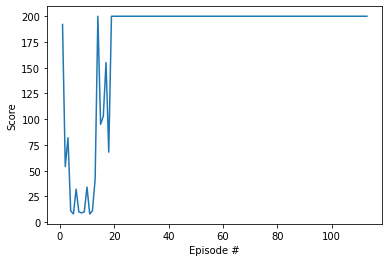

In [5]:
def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.
       
       Psuedo code
       -----------
        Initialize the weights 𝜃 in the policy arbitarily.

        Collect an episode with 𝜃, and record the return G.

        𝜃_best <-- 𝜃, G_best <-- G

        Repeat until environment solved:

            Add a little bit of random noise to 𝜃_best, to get a new set of weight 𝜃_new.

            Collect an episode with 𝜃_new, and record the return G_new.

            if G_new < G_best, then:
                𝜃_best <-- 𝜃_new, G_best <-- G_new

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    
    # initialize
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        if R >= best_R: # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape) 
        else: # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        # Monitor case
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            policy.w = best_w
            break
        
    return scores
            
scores = hill_climbing()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Simulate Trained Agent

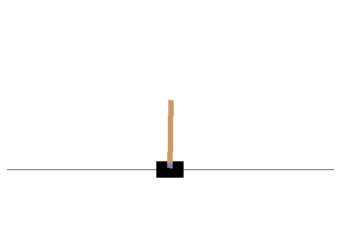

In [6]:
env = gym.make('CartPole-v0')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(200):
    action = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()